In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import low_rank_models as lrm
from sklearn.preprocessing import scale

In [2]:
RANK = 9

In [3]:
df = pd.read_csv('error_matrix_small.csv', index_col=0)
models = np.array(list(df))             # array of all base models
dataset_IDs = df.index.values           # array of openML dataset IDs used
errorMtx = df.values                
n_datasets, n_models = errorMtx.shape

colmeans = np.mean(errorMtx, axis=0)

Conducting pivoted QR factorization on $V^T$ transpose of the SVD of the error matrix. The plot below shows the first `RANK` pivot columns, and their mean values in the error matrix.

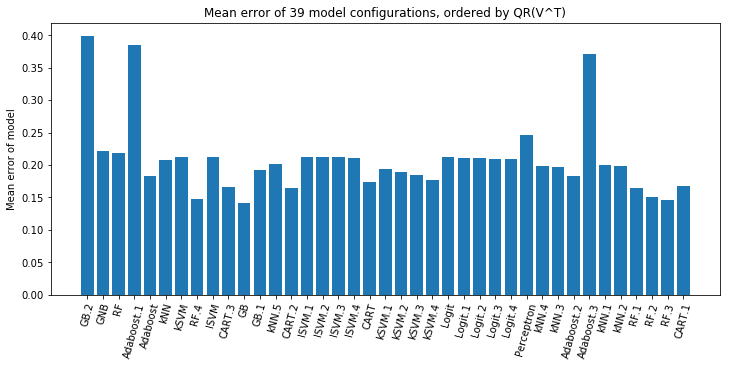

In [4]:
X,Y,Vt = lrm.pca(errorMtx, rank=RANK)
cols1 = lrm.pivoted_qr(Vt)

selected_models = tuple(models[cols1])
y_pos = np.arange(len(selected_models))
mean_error = colmeans[cols1]

plt.figure(figsize=(12,5))
plt.bar(y_pos, mean_error, align='center')
plt.xticks(y_pos, selected_models, rotation=75)
plt.ylabel('Mean error of model')
plt.title('Mean error of 39 model configurations, ordered by QR(V^T)')

plt.show()

Several columns with high means are selected first, while those with low error (i.e. likely to perform well) such as the random forest models are never treated as feasible candidates to be the entries we compute. Interestingly, many of the columns with the same algorithm type cluster together. What happpens when we normalize the columns of $V^T$ to have zero mean and unit variance?

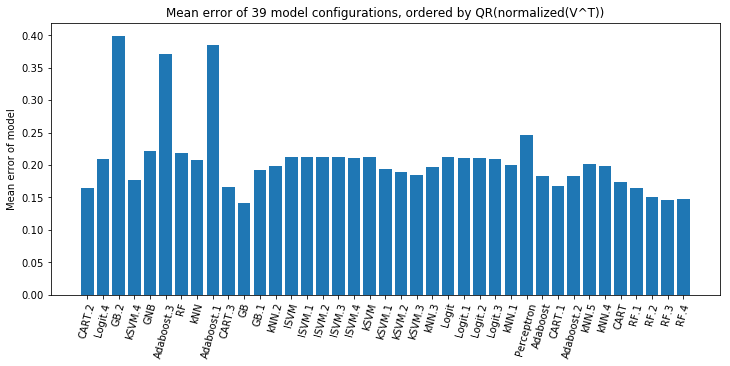

In [5]:
X,Y,Vt = lrm.pca(errorMtx, rank=RANK)
Vt_scaled = scale(Vt)
cols2 = lrm.pivoted_qr(Vt_scaled)

selected_models = tuple(models[cols2])
y_pos = np.arange(len(selected_models))
mean_error = colmeans[cols2]

plt.figure(figsize=(12,5))
plt.bar(y_pos, mean_error, align='center')
plt.xticks(y_pos, selected_models, rotation=75)
plt.ylabel('Mean error of model')
plt.title('Mean error of 39 model configurations, ordered by QR(normalized(V^T))')

plt.show()

Although there is some change in ordering, the index-1 Adaboost and index-2 Gradient boosting algorithms are still selected as being the most orthogonal columns, and the random forest models remain at the end.

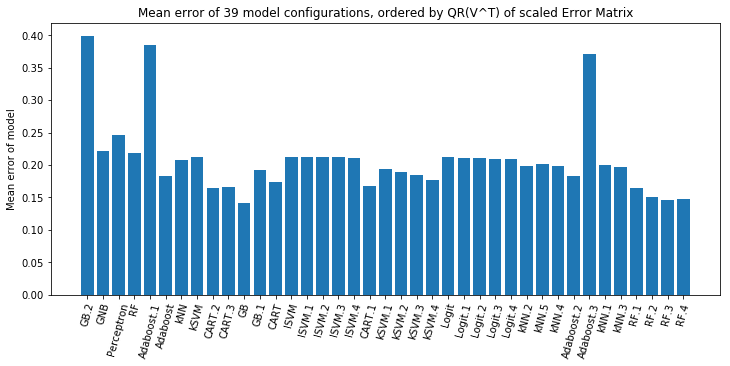

In [6]:
errorMtx_scaled = scale(errorMtx, axis=1)
X,Y,Vt = lrm.pca(errorMtx_scaled, rank=RANK)

cols3 = lrm.pivoted_qr(Vt)

selected_models = tuple(models[cols3])
y_pos = np.arange(len(selected_models))
mean_error = colmeans[cols3]

plt.figure(figsize=(12,5))
plt.bar(y_pos, mean_error, align='center')
plt.xticks(y_pos, selected_models, rotation=75)
plt.ylabel('Mean error of model')
plt.title('Mean error of 39 model configurations, ordered by QR(V^T) of scaled Error Matrix')

plt.show()

Identical to first plot - QR factorization is invariant to scaling (?)

In [7]:
def sameAlg(testBestCol):
    testBestAlgType = []
    for i in range(len(testBestCol)):
        # testBestAlgType.append(eval(models[testBestCol[i]])['algorithm'])
        testBestAlgType.append(models[testBestCol[i]].split('.')[0])
    return np.array(testBestAlgType)

In [8]:
bestModel = np.argmin(errorMtx, axis=1)
bestAlg = sameAlg(bestModel)
bestError = np.min(errorMtx, axis=1)

methods = ['QR(Vt)', 'QR(scaled(Vt))']
cols = {'QR(Vt)':cols1, 'QR(scaled(Vt))':cols2}

In [9]:
predictions = {}
for m in methods:    
    predicted = ()
    for i in range(n_datasets):
        a = errorMtx[i].reshape(1,-1)
        A = np.delete(errorMtx, i, axis=0)
        a_hat = np.zeros((1, n_models))
        X,Y,_ = lrm.pca(A, rank=RANK)
        sampled_cols = cols[m][:RANK]
        a_hat[:,sampled_cols] = a[:,sampled_cols]
        a_hat = lrm.low_rank_approximation(A, a_hat, sampled_cols)
        predicted += (np.argsort(a_hat),)
    predictions[m] = np.vstack(predicted)

In [10]:
correct_model = []
correct_alg = []
error_diff = []

for m in methods:
    prediction = predictions[m]
    
    cm = np.zeros(n_models)
    ca = np.zeros((n_datasets, n_models)).astype(int)
    ed = np.zeros((n_datasets, n_models))
    
    for i in range(n_models):
        cm[i] = (prediction[:,i] == bestModel).sum()
        for j in range(n_datasets):
            ed[j,i] = errorMtx[j, prediction[j,i]] - bestError[j]
        if i==0:
            ca[:,i] = sameAlg(prediction[:,i]) == bestAlg
        else:
            ca[:,i] = np.logical_or(ca[:,i-1], sameAlg(prediction[:,i]) == bestAlg)
    for j in range(n_datasets):
        ed[j] = np.minimum.accumulate(ed[j])
            
    correct_model.append(np.cumsum(cm))
    correct_alg.append(np.sum(ca, axis=0))
    error_diff.append(np.mean(ed, axis=0))   

In [11]:
max_entries = 20
fontsize = 11

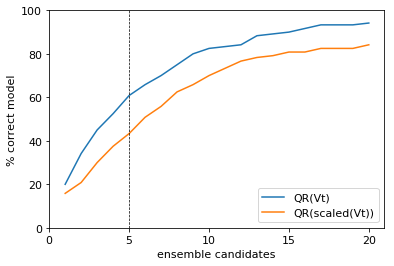

In [12]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, correct_model[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks([0,20,40,60,80,100], fontsize=fontsize)
plt.ylabel('% correct model', fontsize=fontsize)
plt.show()

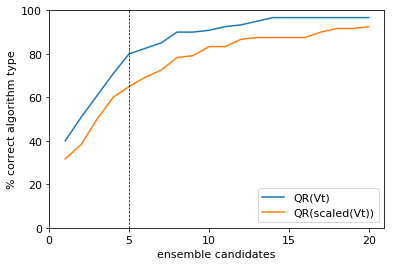

In [13]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, correct_alg[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks([0,20,40,60,80,100], fontsize=fontsize)
plt.ylabel('% correct algorithm type', fontsize=fontsize)
plt.show()

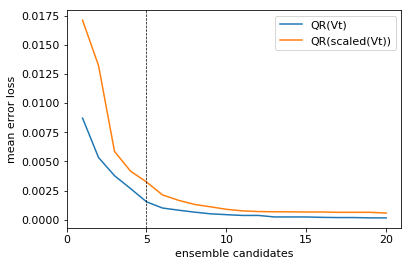

In [14]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, error_diff[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='upper right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('mean error loss', fontsize=fontsize)
plt.show()